In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
# Blanchard Kahn solution
class ReturnBK(object):
    def __init__(self, H, R, F, Q, condition):
        self.H = H
        self.R = R
        self.F = F
        self.Q = Q
        self.condition = condition

def BlanchardKahn(A0,A1,B,n,m):
    # Finds solution to the following model: A0 y[t+1] = A1 y[t] + B e[t+1]
    # m: number of non-predetermined (or forward-looking) variables
    
    invA0 = np.linalg.inv(A0)
    A = np.dot(invA0,A1)
    
    Lambda,P = np.linalg.eig(A)
    if sum(np.abs(Lambda)>1)==m:

        idx=np.abs(Lambda).argsort()

        Lambda = np.diag(Lambda[idx])
        P = P[:,idx]

        invP = np.linalg.inv(P)

        Pstar11 = np.real(invP[:n,:n])
        Pstar12 = np.real(invP[:n,n:])
        Pstar21 = np.real(invP[n:,:n])
        Pstar22 = np.real(invP[n:,n:])

        invPstar22 = np.linalg.inv(Pstar22)
        invPstarss = np.linalg.inv(Pstar11 - np.dot(np.dot(Pstar12,invPstar22),Pstar21))


        Lambda1 = np.real(Lambda[:n,:n])
        Lambda2 = np.real(Lambda[n:,n:])

        Q = np.dot(np.dot(invP,invA0),B)
        Q1 = np.real(Q[:n,:n])
        Q2 = np.real(Q[n:,n:])

        H_bk = -np.dot(invPstar22,Pstar21)
        R_bk = np.zeros(shape=(H_bk.shape[0],H_bk.shape[0]))
        F_bk = np.dot(np.dot(invPstarss,Lambda1),Pstar11 - np.dot(np.dot(Pstar12,invPstar22),Pstar21))
        Q_bk = np.dot(invPstarss,Q1)
        
        # Final results
        H = np.concatenate((np.identity(m),np.zeros((m,n))),axis=1)
        R = np.zeros((m,m))
        
        F = np.concatenate((np.zeros((m+n,m)),np.concatenate((np.dot(H_bk,F_bk),F_bk),axis=0)),axis=1)
        Q = np.diagflat(np.sqrt(np.abs(np.concatenate((np.dot(H_bk,Q_bk),Q_bk),axis=0))))
        
        condition = True

    else: # Blanchard Kahn condition not attended
        H=np.nan
        R=np.nan
        F=np.nan
        Q=np.nan
        condition = False
    
    return ReturnBK(H, R, F, Q, condition)

In [3]:
# Kalman filter
class ReturnKF(object):
    def __init__(self, yHat, aMinus, VMinus, L):
        self.yHat = yHat
        self.aMinus = aMinus
        self.VMinus = VMinus
        self.L = L

def KalmanFilter(H, R, F, Q, y, forecast):
    # Useful variables and matrices
    m = H.shape[1]
    p = H.shape[0]
    T = y.shape[0] + forecast
    
    yHat   = np.zeros((T  ,p))
    yFull  = np.concatenate((np.array(y),np.nan*np.zeros((forecast,p))),axis=0)
    
    nu     = np.zeros((T  ,p))
    a      = np.zeros((T  ,m))
    aMinus = np.zeros((T+1,m))
    
    S      = np.zeros((T  ,p,p))
    V      = np.zeros((T  ,m,m))
    VMinus = np.array([np.identity(m) for t in range(T+1)])
    K      = np.zeros((T  ,m,p))
    
    Ht     = np.transpose(H)
    Ft     = np.transpose(F)
    
    L=0.0
    
    # Recursevely calculates the Kalman filter
    for t in range(T):
        # Filtered values
        yHat[t] = np.dot(H,aMinus[t])

        for i in range(p):
            if np.isnan(yFull[t][i]):
                yFull[t][i] = yHat[t][i]

        # Update equations    
        nu[t] = yFull[t] - np.dot(H,aMinus[t])
        S[t]  = np.dot(np.dot(H,VMinus[t]),Ht) + R
        K[t]  = np.dot(np.dot(VMinus[t],Ht),np.linalg.inv(S[t]))
        a[t]  = aMinus[t] + np.dot(K[t],nu[t])
        V[t]  = np.dot((np.identity(m)-np.dot(K[t],H)),VMinus[t])

        # Forecast equations
        aMinus[t+1] = np.dot(F,a[t])
        VMinus[t+1] = np.dot(np.dot(F,V[t]),Ft) + Q
        
    # Calculates likelihood
    for t in range(T):
        L = L + np.linalg.det(S[t]) + np.dot(np.dot(np.transpose(nu[t]),np.linalg.inv(S[t])),nu[t])

    L = -T*p/2* np.log(2*np.pi) - 1/2 * L
        
    return ReturnKF(yHat, aMinus, VMinus, L)


In [4]:
# Model
class ReturnModel(object):
    def __init__(self, A0, A1, B):
        self.A0 = A0
        self.A1 = A1
        self.B = B

def modelator(sigma,beta,rho,phi_pi,v,omega,alpha):
    kappa = (1-omega)*(1-beta*omega)/(alpha*omega)
    A0 = np.array([[1,0,       0],
                   [0,1, 1/sigma],
                   [0,0,    beta]])
    A1 = np.array([[    rho,     0,           0],
                   [1/sigma,     1,phi_pi/sigma],
                   [      0,-kappa,           1]])
    B = np.array([[v],
                  [0],
                  [0]])
    
    return ReturnModel(A0, A1, B)

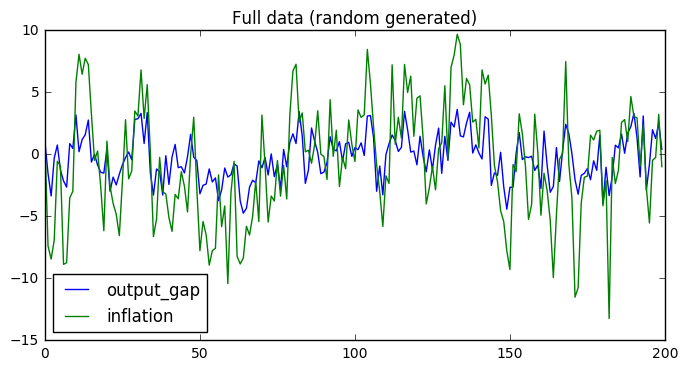

In [5]:
# Generates some random data

# Value of "true" parameters ...
sigma = 1.0
beta = 0.99
rho = 0.75
phi_pi = 1.5
v = 1
omega = 0.5
alpha = 3.0

kappa = (1-omega)*(1-beta*omega)/(alpha*omega)

# ... in BK matrices
A0 = np.array([[1,0,       0],
               [0,1, 1/sigma],
               [0,0,    beta]])

A1 = np.array([[    rho,     0,           0],
               [1/sigma,     1,phi_pi/sigma],
               [      0,-kappa,           1]])

B = np.array([[v],
              [0],
              [0]])

# ...in KF matrices
BK = BlanchardKahn(A0,A1,B,1,2)

# generates output gap and inflation consistent with the model
T = 200
m = BK.H.shape[1]
p = BK.H.shape[0]

y = np.array([[1.0 for i in range(p)] for t in range(T)])
x = np.array([[1.0 for i in range(m)] for t in range(T)])
    
for t in range(T):
    if p==1:
        if BK.R==0:
            y[t] = np.dot(BK.H,x[t])
        else:
            y[t] = y[t] + np.random.normal(0,BK.R)
    else:
        if np.all(BK.R==np.zeros(shape=(p,p))):
            y[t] = np.dot(BK.H,x[t])
        else:
            y[t] = np.dot(BK.H,x[t]) + np.random.multivariate_normal(np.zeros(p),BK.R)
        
    if t+1<T:
        if m==1:
            if BK.Q==0:
                x[t+1] = np.dot(BK.F,x[t])
            else:
                x[t+1] = np.dot(BK.F,x[t]) + np.random.normal(0,BK.Q)
        else:
            if np.all(BK.Q==np.zeros(shape=(m,m))):
                x[t+1] = np.dot(BK.F,x[t])
            else:
                x[t+1] = np.dot(BK.F,x[t]) + np.random.multivariate_normal(np.zeros(m),BK.Q)

completeData = pd.DataFrame(y,columns=['output_gap','inflation'])
                
# Plot
figComplete = plt.figure(figsize=(8,4))
axComplete = figComplete.add_subplot(111)
axComplete.plot(completeData.index, completeData);

# Cleanup
axComplete.legend([label for label in completeData.columns],loc='best')
axComplete.set_title('Full data (random generated)');


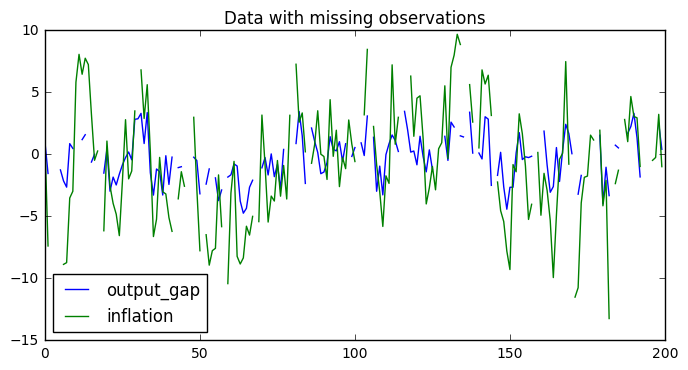

In [6]:
# Drop some data points...
missingData = pd.DataFrame(completeData)
probMiss = 0.1
for t in missingData.index:
    for i in missingData.columns:
        if np.random.rand()<probMiss:
            missingData.loc[t,i]=np.nan
# ... and some data rows
probMiss = 0.1
for t in missingData.index:
    if np.random.rand()<probMiss:
        missingData.loc[t,:]=np.nan

# Plot
figMissing = plt.figure(figsize=(8,4))
axMissing = figMissing.add_subplot(111)
axMissing.plot(missingData.index, missingData);

# Cleanup
axMissing.legend([label for label in missingData.columns],loc='best')
axMissing.set_title('Data with missing observations');


In [6]:
#%%timeit
#BK = BlanchardKahn(A0,A1,B,1,2)
#KF = KalmanFilter(BK.H, BK.R, BK.F, BK.Q, missingData, 10)

100 loops, best of 3: 15.6 ms per loop


In [72]:
### Metropolis hastings

# set model fixed parameters
sigma = 1.0
beta = 0.99
rho = 0.75
# phi_pi = 1.5
v = 1
omega = 0.5
alpha = 3.0
# kappa = (1-omega)*(1-beta*omega)/(alpha*omega)

# Set priors PDFs
def phiPrior(x):
    #return stats.chi2.pdf((x-1)*10, 3)
    return stats.norm(2,0.1).pdf(x)

# Set MH parameters
k = 0.1
n = 100000
start = 1.6
burn_in = .1
theta=start
    
sample = pd.DataFrame({'theta':np.nan},index=range(n))
sample.theta[0] = theta

# Calculates initial BK, KF
model = modelator(sigma,beta,rho,theta,v,omega,alpha)

# ...in KF matrices
BK = BlanchardKahn(model.A0,model.A1,model.B,1,2)
if BK.condition==False:
    print("Bad initial theta")
else:
    logL = KalmanFilter(BK.H, BK.R, BK.F, BK.Q, completeData, 0).L
    
    i=1
    
    print('Simulating...')
    print('0%       |10%      |20%      |30%      |40%      |50%      |60%      |70%      |80%      |90%      |100%')
    
    while(i<n):
        
        # Draw q(theta1 | theta0)
        newTheta = theta + np.random.normal(0,k)

        # Solves BK
        model = modelator(sigma,beta,rho,newTheta,v,omega,alpha)
        try:
            BK = BlanchardKahn(model.A0,model.A1,model.B,1,2)

            if BK.condition==True:
                KF = KalmanFilter(BK.H, BK.R, BK.F, BK.Q, missingData, 0)

                # Compute acceptance ratio
                posterior = logL -np.log(phiPrior(theta))
                newPosterior = KF.L + np.log(phiPrior(newTheta))
                acceptanceRatio = np.exp(KF.L + np.log(phiPrior(newTheta)) - logL -np.log(phiPrior(theta)))

                # Compute r = min(1,acceptance ratio)
                r = min(1,acceptanceRatio)

                # Accept or reject new theta
                u = np.random.uniform(0,1)

                if u<r:
                    theta = newTheta
                    sample.theta[i] = theta
                    logL - KF.L
                    i = i+1
                    if int(i*100/n)==i*100/n: print('#',end='')
        except Exception:
            pass
            

    sample = sample[int(-(1-burn_in)*n):]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:55: RuntimeWarning: overflow encountered in exp


1.0
2.0


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: divide by zero encountered in log
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:55: RuntimeWarning: divide by zero encountered in log


3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0


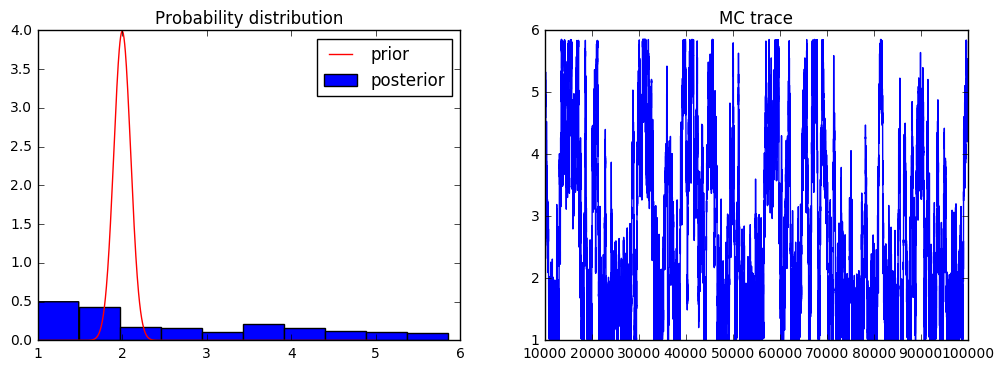

In [78]:
# Plot
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)

## Plot MCMC sample
ax1.hist(sample['theta'], normed=True)

X = np.linspace(1,5, 1000)
ax1.plot(X, phiPrior(X), 'r')
ax1.set_title('Probability distribution')
ax1.legend(['prior','posterior'],loc='best')

ax2 = fig.add_subplot(122)
ax2.set_title('MC trace')
ax2.plot(sample['theta']);

In [79]:
sample.median()

theta    2.272756
dtype: float64